# Unsupervised Learning Lab

In this lab you will work through several examples of methods and applications of unsupervised learning. We will be working with the **Digits** dataset of of handwritten numbers. This dataset is convenient because Scikit-learn provides it built-in.

**NOTE**: I do not explicitly *ask* for your analyses in this notebook, but you should definitely provide them!

.. _digits_dataset:

Optical recognition of handwritten digits dataset
--------------------------------------------------

**Data Set Characteristics:**

    :Number of Instances: 1797
    :Number of Attributes: 64
    :Attribute Information: 8x8 image of integer pixels in the range 0..16.
    :Missing Attribute Values: None
    :Creator: E. Alpaydin (alpaydin '@' boun.edu.tr)
    :Date: July; 1998

This is a copy of the test set of the UCI ML hand-written digits datasets
https://archive.ics.uci.edu/ml/datasets/Optical+Recognition+of+Handwritten+Digits

The data set contains images of hand-written digits: 10 classes where
each class refers to a digit.

Preprocessing programs made available by NIST were used to extract
normalized bitmaps of handwritten digits from a preprinted form. From a
total of 43 people, 30 contributed to the training set and different 13
to the test set. 32x32 bitmaps are divided into nonoverlapping blocks of
4x4 and the number of on pixels are counted in each blo

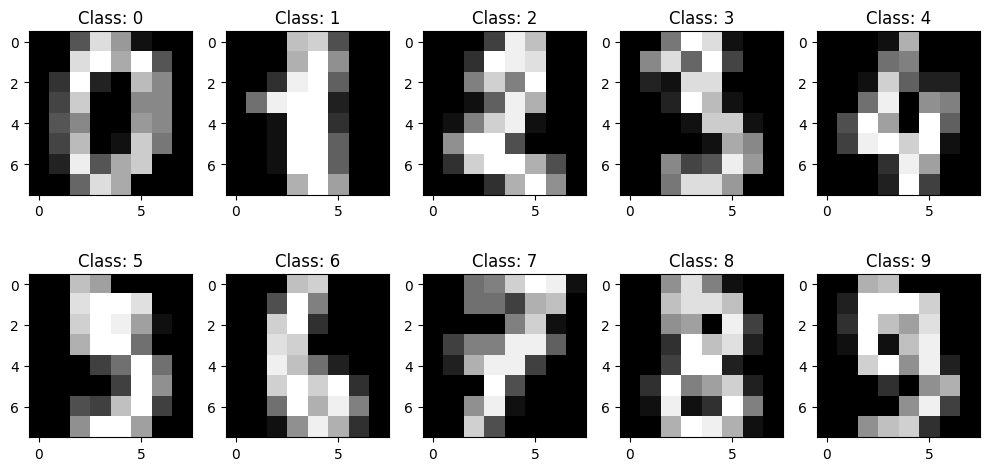

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import load_digits
import pandas as pd
from sklearn.preprocessing import StandardScaler

# Load the digits dataset and extract data and labels.
ds_digits = load_digits()
Xs = ds_digits.data
ys = ds_digits.target

scaler = StandardScaler()
Xs = scaler.fit_transform(Xs)

# Create a pandas DataFrame 'df_digits' to hold the dataset's features.
# Note: This dataset doesn't have column names as it represents image pixel values.
df_digits = pd.DataFrame(ds_digits.data)

# Create a pandas Series 'targets_digits' to store the target labels of the dataset.
targets_digits = pd.Series(ds_digits.target)

# Print the description of the dataset using 'DESCR' attribute of 'ds_digits'.
print(ds_digits['DESCR'])

# Print the statistical summary of the features in the dataset using 'describe' method of 'df_digits'.
print(df_digits.describe())

# Access and print the column names (feature names) of the dataset using 'feature_names' attribute of 'ds_digits'.
column_names = ds_digits['feature_names']
print(column_names)

# Create a 5x5 grid of subplots with a defined figure size
fig, axes = plt.subplots(2, 5, figsize=(10, 5))

# Plot the 10 classes and their corresponding labels in the dataset
for i in range(10):
    row = i // 5  # Determine the row position (0 to 4)
    col = i % 5   # Determine the column position (0 to 4)

    # Display the image using grayscale colormap
    axes[row, col].imshow(ds_digits.images[i], cmap='gray')

    # Set the title for the subplot with the image label
    axes[row, col].set_title(f"Class: {ds_digits.target[i]}")

# Adjust the spacing between subplots for better layout
plt.tight_layout()

# Display the subplots
plt.show()

**Data Set Characteristics:**

    :Number of Instances: 1797
    :Number of Attributes: 64
    :Attribute Information: 8x8 image of integer pixels in the range 0..16.
    :Missing Attribute Values: None
    :Creator: E. Alpaydin (alpaydin '@' boun.edu.tr)
    :Date: July; 1998

This is a copy of the test set of the UCI ML hand-written digits datasets
https://archive.ics.uci.edu/ml/datasets/Optical+Recognition+of+Handwritten+Digits

The data set contains images of hand-written digits: 10 classes where
each class refers to a digit.

Preprocessing programs made available by NIST were used to extract
normalized bitmaps of handwritten digits from a preprinted form. From a
total of 43 people, 30 contributed to the training set and different 13
to the test set. 32x32 bitmaps are divided into nonoverlapping blocks of
4x4 and the number of on pixels are counted in each block. This generates
an input matrix of 8x8 where each element is an integer in the range
0..16. This reduces dimensionality and gives invariance to small
distortions.

For info on NIST preprocessing routines, see M. D. Garris, J. L. Blue, G.
T. Candela, D. L. Dimmick, J. Geist, P. J. Grother, S. A. Janet, and C.
L. Wilson, NIST Form-Based Handprint Recognition System, NISTIR 5469,
1994.

.. topic:: References

  - C. Kaynak (1995) Methods of Combining Multiple Classifiers and Their
    Applications to Handwritten Digit Recognition, MSc Thesis, Institute of
    Graduate Studies in Science and Engineering, Bogazici University.
  - E. Alpaydin, C. Kaynak (1998) Cascading Classifiers, Kybernetika.
  - Ken Tang and Ponnuthurai N. Suganthan and Xi Yao and A. Kai Qin.
    Linear dimensionalityreduction using relevance weighted LDA. School of
    Electrical and Electronic Engineering Nanyang Technological University.
    2005.
  - Claudio Gentile. A New Approximate Maximal Margin Classification
    Algorithm. NIPS. 2000.

           0            1            2            3            4   \
count  1797.0  1797.000000  1797.000000  1797.000000  1797.000000   
mean      0.0     0.303840     5.204786    11.835838    11.848080   
std       0.0     0.907192     4.754826     4.248842     4.287388   
min       0.0     0.000000     0.000000     0.000000     0.000000   
25%       0.0     0.000000     1.000000    10.000000    10.000000   
50%       0.0     0.000000     4.000000    13.000000    13.000000   
75%       0.0     0.000000     9.000000    15.000000    15.000000   
max       0.0     8.000000    16.000000    16.000000    16.000000   

                5            6            7            8            9   ...  \
count  1797.000000  1797.000000  1797.000000  1797.000000  1797.000000  ...   
mean      5.781859     1.362270     0.129661     0.005565     1.993879  ...   
std       5.666418     3.325775     1.037383     0.094222     3.196160  ...   
min       0.000000     0.000000     0.000000     0.000000     0.000000  ...   
25%       0.000000     0.000000     0.000000     0.000000     0.000000  ...   
50%       4.000000     0.000000     0.000000     0.000000     0.000000  ...   
75%      11.000000     0.000000     0.000000     0.000000     3.000000  ...   
max      16.000000    16.000000    15.000000     2.000000    16.000000  ...   

                54           55           56           57           58  \
count  1797.000000  1797.000000  1797.000000  1797.000000  1797.000000   
mean      3.725097     0.206455     0.000556     0.279354     5.557596   
std       4.919406     0.984401     0.023590     0.934302     5.103019   
min       0.000000     0.000000     0.000000     0.000000     0.000000   
25%       0.000000     0.000000     0.000000     0.000000     1.000000   
50%       1.000000     0.000000     0.000000     0.000000     4.000000   
75%       7.000000     0.000000     0.000000     0.000000    10.000000   
max      16.000000    13.000000     1.000000     9.000000    16.000000   

                59           60           61           62           63  
count  1797.000000  1797.000000  1797.000000  1797.000000  1797.000000  
mean     12.089037    11.809126     6.764051     2.067891     0.364496  
std       4.374694     4.933947     5.900623     4.090548     1.860122  
min       0.000000     0.000000     0.000000     0.000000     0.000000  
25%      11.000000    10.000000     0.000000     0.000000     0.000000  
50%      13.000000    14.000000     6.000000     0.000000     0.000000  
75%      16.000000    16.000000    12.000000     2.000000     0.000000  
max      16.000000    16.000000    16.000000    16.000000    16.000000  

## 1. Clustering
In this set of exercises we will experiment with clustering of the digits dataset. One use of unsupervised techniques like K-Means Clustering is to use the discovered cluster structure to *induce* a classifier.  

### Exercise 1.1: K-means clustering
Use K-means clustering to cluster the digits dataset into 10 clusters (i.e. the "*correct*" number of clusters). After clustering the data, for each cluster center compute the sum-of-squared-distances to it and all points assigned to its cluster. This is called the cluster *inertia* and is a measure of cluster compactness.

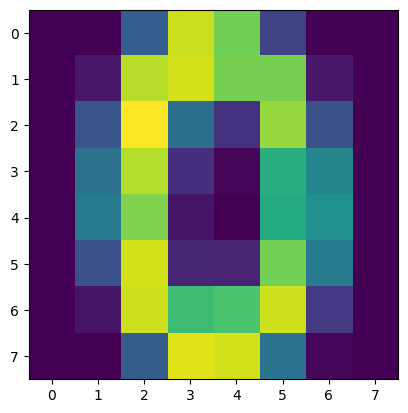

In [3]:
from scipy.spatial.distance import cdist


def kmeans(Xs, K=10, num_iter=1000):
    # Get the shape of the data
    (N, D) = Xs.shape

    # Initialize cluster centers randomly 
    means = 2.0 * np.random.rand(K, D) - 1.0

    # Perform K-means iterations
    for _ in range(num_iter):
        # Compute distances between data points and cluster centers
        distances = cdist(Xs, means)

        # Assign each data point to the cluster with the closest center
        I = np.argmin(distances, axis=1)

        # Update cluster centers using vectorized operations
        means = np.array([np.mean(Xs[I == c], axis=0) for c in range(K)])

    # Final assignment of data points to clusters
    I = np.argmin(distances, axis=1)
    return means, I


# Example usage
(means, cluster_assignments) = kmeans(Xs)
# Inverse transform means (if applicable)
means = scaler.inverse_transform(means)

# Display an image of the cluster center for cluster 5
plt.imshow(means[5].reshape(8, 8))

It's important to note that K-means is sensitive to initialization, and the quality of the clusters depends on the data and the chosen hyperparameters


Inertia per cluster:
Cluster 0: 5370.94
Cluster 1: 13260.88
Cluster 2: 8136.22
Cluster 3: 2962.47
Cluster 4: 14759.86
Cluster 5: 3728.37
Cluster 6: 3322.59
Cluster 7: 5152.36
Cluster 8: 3544.58
Cluster 9: 9166.16

The minimum inertia is 2962.47 for cluster number 3
The average silhouette score is: 0.15


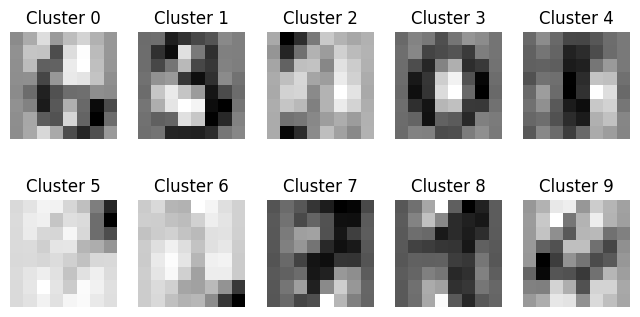

In [4]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

# Perform K-means clustering with 10 clusters
kmeans = KMeans(n_clusters=10, random_state=42, n_init=1000)
kmeans.fit(Xs)

# Get cluster centers and labels
cluster_centers = kmeans.cluster_centers_  # The actual centroids
labels = kmeans.labels_

# Calculate inertia per cluster
inertia_per_cluster = np.zeros(10)
for i in range(10):
    cluster_points = Xs[labels == i]
    inertia_per_cluster[i] = np.sum((cluster_points - cluster_centers[i]) ** 2)

# Print the results
print("\nInertia per cluster:")
for i, inertia in enumerate(inertia_per_cluster):
    print(f"Cluster {i}: {inertia:.2f}")

print(
    f"\nThe minimum inertia is {inertia_per_cluster.min():.2f} for cluster number {inertia_per_cluster.argmin()}")

#Calculate the average silhouette score to compare cohesion
silhouette_avg = silhouette_score(Xs, labels)
print(f"The average silhouette score is: {silhouette_avg:.2f}")

# Visualize the cluster centers
fig, ax = plt.subplots(2, 5, figsize=(8, 4))
for i, axi in enumerate(ax.flat):
    axi.imshow(cluster_centers[i].reshape(8, 8), cmap='binary')
    axi.set_title(f"Cluster {i}")
    axi.axis('off')

plt.show()

**MY ANALYSIS:**
 The code is pretty easy. We use the KMeans class to perform K-means clustering and the inertia is calculated for each cluster --> lower inertia indicates tighter cluster.
The plot shows us the the image of a cluster center.
however, inertia does not seem to me to be the best way to analyze the dispersion of values relating to a given cluster. If we had as many clusters as points we could have an inertia equal to 0. To avoid this situation we use the silhouette score method.


The silhouette score is a measure of how similar an object is to its own cluster (cohesion) compared to other clusters (separation). It quantifies the separation distance between clusters.
On the other hand, the inertia, or within-cluster sum of squares, measures how far the points within a cluster are from the centroid of that cluster. It is a measure of the compactness of the clusters. While inertia is an internal evaluation metric specific to K-means, the silhouette score is a more general measure of cluster quality that can be used across different clustering algorithms. It provides additional insights into the cohesion and separation of clusters. A higher silhouette score suggests better-defined clusters.

As expected, the average value of the silhouette method is close to 0, this means that we have overlapping clusters. This will be confirmed in the next section.



**COOL:**
In the context of the K-means algorithm applied to the digits dataset, each centroid would represent the average pixel values of the digits within a particular cluster.

### Exercise 1.2: Transforming our clustering into a classifier
Now use the labels in `ys` to compute a probability distribution over all classes (i.e. a *histogram*) for each cluster. Write a function that, given a test sample $\mathbf{x}$, returns the class with maximum likelihood given by the closest cluster center. Evaluate your classifier. Compute the entropy for each cluster based on your estimated probability distributiont. Does the entropy of a cluster correlate to misclassifications of test samples closest to it?

**Note**: since you will be testing this classifier, you will want to carefully split the data into *training* and *test* splits.



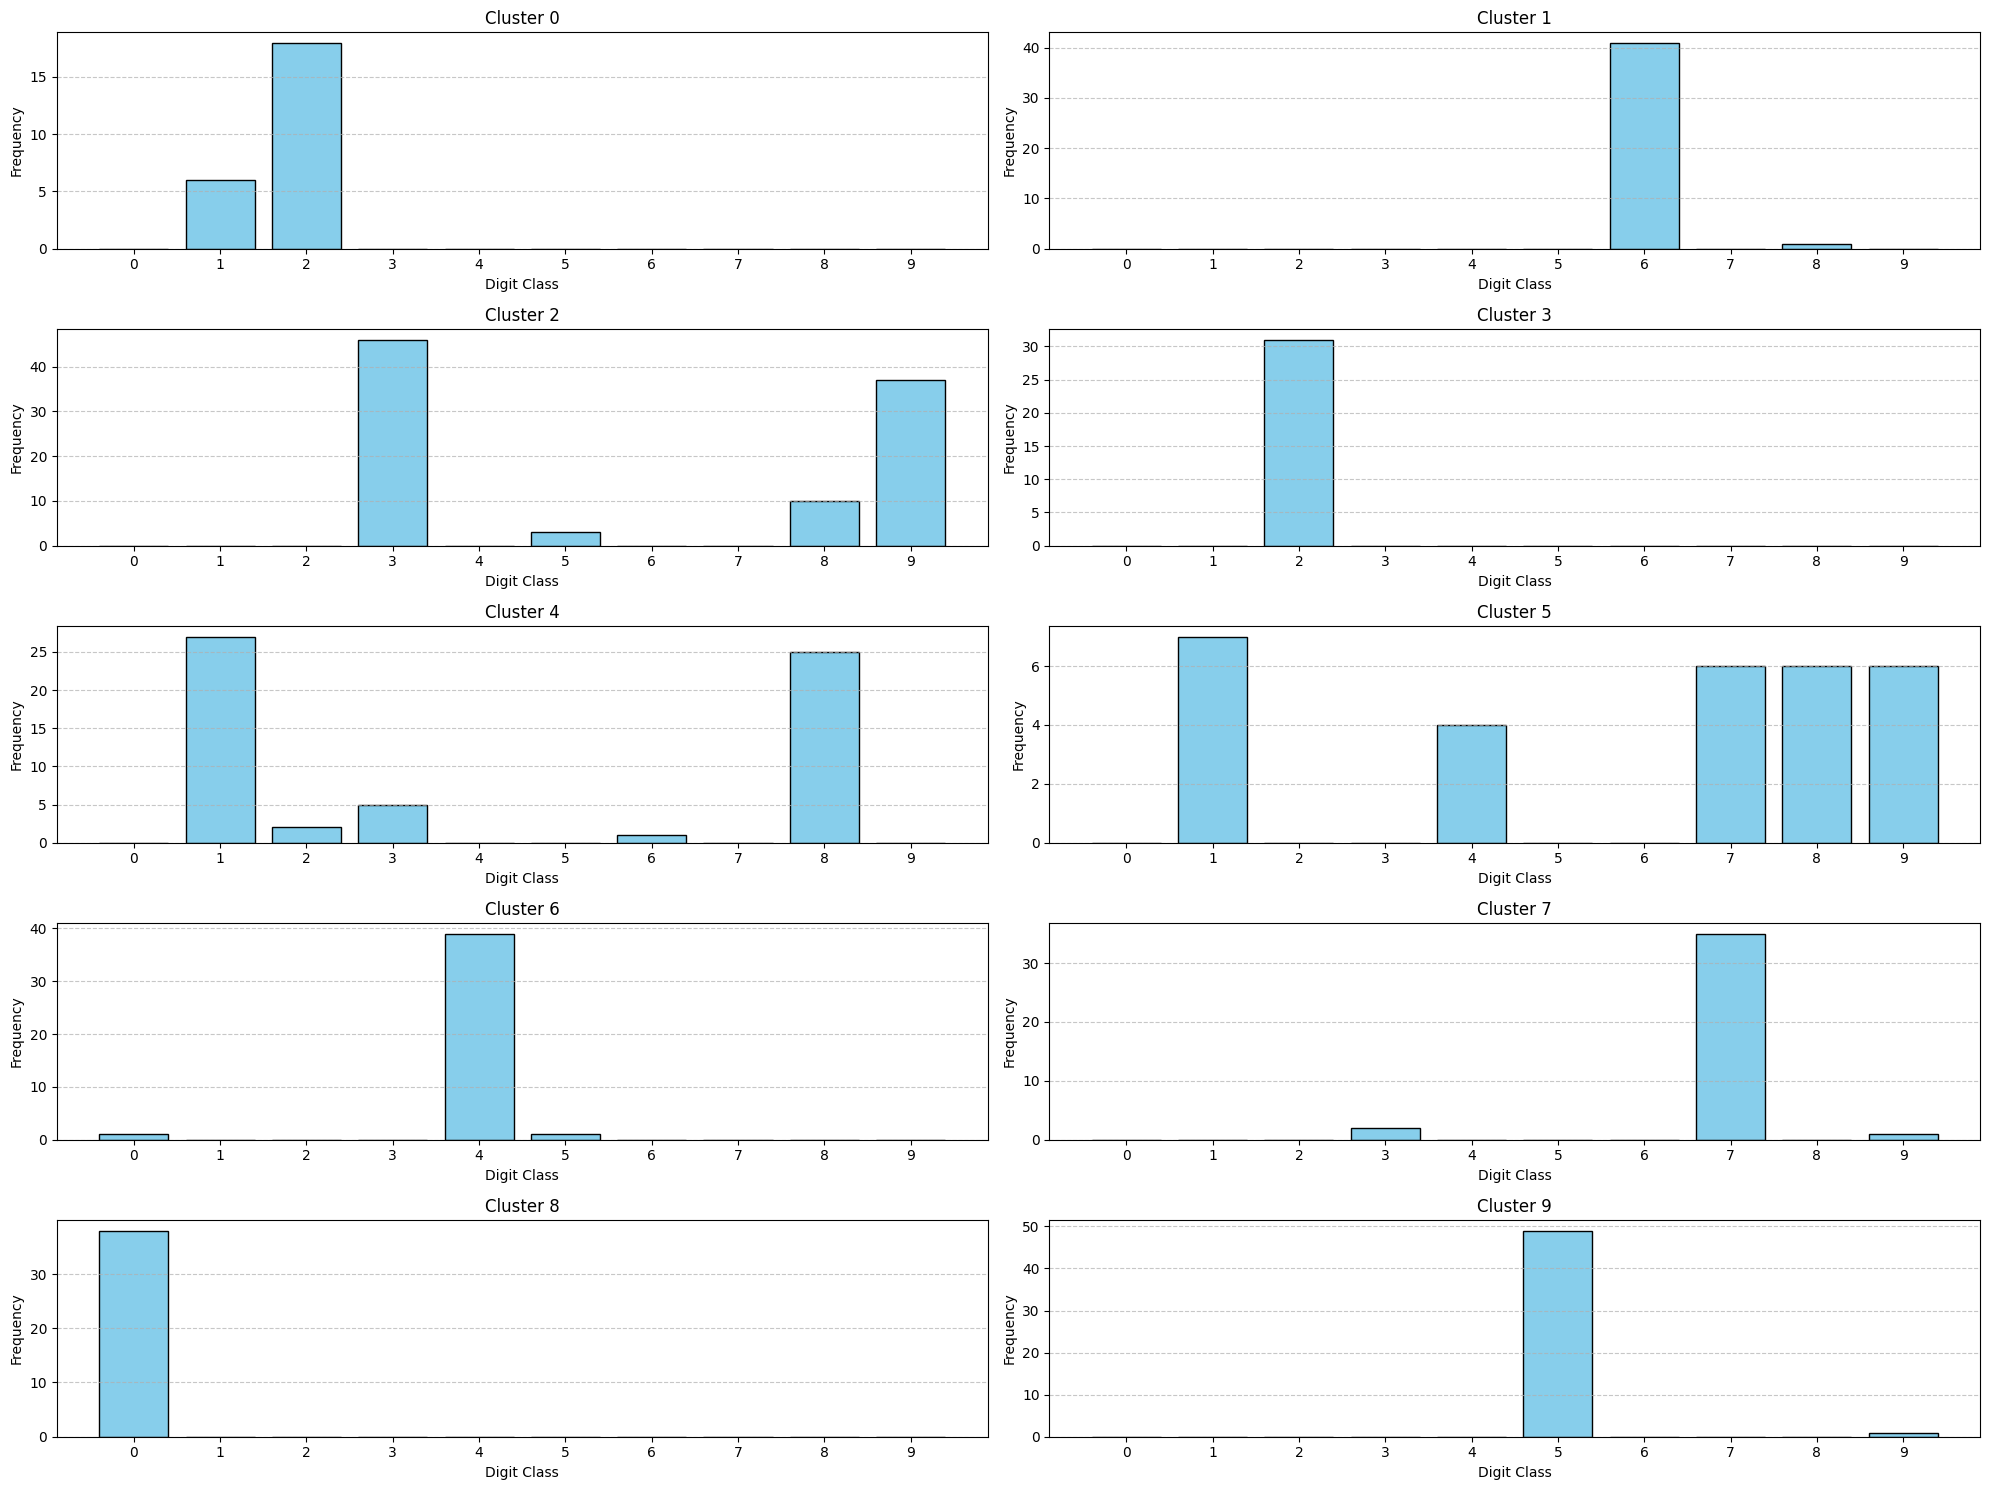

[0.8112781244591328,
 0.1623261801753929,
 1.5348813240760435,
 -0.0,
 1.6054237993215423,
 2.300022047976398,
 0.3299742842369207,
 0.4709563136258532,
 -0.0,
 0.14144054254182067]

In [11]:
from sklearn.model_selection import train_test_split

# Split the dataset into training and test sets
Xtr, Xte, ytr, yte = train_test_split(df_digits, targets_digits, test_size=0.75)

# Fit K-means clustering on the training data
kmeans.fit(Xtr)
cluster_labels = kmeans.predict(Xtr)

def entropy(probabilities):
    # Remove zero probabilities to avoid log(0) issues
    non_zero_probs = probabilities[probabilities > 0]

    # Calculate entropy using the formula
    entropy_value = -np.sum(non_zero_probs * np.log2(non_zero_probs))
    return entropy_value

# Function to plot histograms for each cluster and return cluster probabilities
def plot_cluster_histograms_probabilities(cluster_labels, true_labels):
    unique_clusters = np.unique(cluster_labels)
    num_clusters = len(unique_clusters)
    
    cluster_probabilities = []

    # Define the number of rows and columns for subplots
    rows = (num_clusters + 1) // 2  # Ensure an even number of subplots in each row
    cols = 2

    # Create subplots
    fig, axes = plt.subplots(rows, cols, figsize=(20, 15))

    for i, cluster_id in enumerate(unique_clusters):
        mask = (cluster_labels == cluster_id)
        cluster_classes = true_labels[mask]

        # Calculate relative frequencies (probabilities) for each class
        class_counts = np.bincount(cluster_classes)
        class_probabilities = class_counts / len(cluster_classes)

        cluster_probabilities.append(class_probabilities)
        
        # Determine subplot position
        if rows > 1:
            ax = axes[i // cols, i % cols]
        else:
            ax = axes[i]
        # Plot histogram for the current cluster
        ax.hist(cluster_classes, bins=np.arange(11) - 0.5, rwidth=0.8, color='skyblue', edgecolor='black')
        ax.set_title(f'Cluster {cluster_id}')
        ax.set_xlabel('Digit Class')
        ax.set_ylabel('Frequency')
        ax.set_xticks(range(10))
        ax.grid(axis='y', linestyle='--', alpha=0.7)
        
    # Adjust layout and show the subplots
    plt.tight_layout()
    plt.show()
    
    return cluster_probabilities

# Example: Plot histograms for each cluster and compute cluster entropies
cluster_probabilities = plot_cluster_histograms_probabilities(cluster_labels, ytr)
cluster_entropies = [entropy(probabilities) for probabilities in cluster_probabilities]
cluster_entropies


In [ ]:
import numpy as np

class KMClassifier:
    def __init__(self, K = 10, num_classes = 10):
        self.K_ = K
        self.model_ = KMeans(n_clusters=K)
        self.num_classes = num_classes
        
    def fit(self, Xs, yx):
        self.model_.fit(Xs)
        self.labels_ = []
        for c in range(self.K_):
            assigned = ys[self.model_.labels_ == c]
            self.labels_.append(np.array([(assigned == cls).sum() for cls in range(self.num_classes)]))
        self.labels_ = np.argmax(np.vstack(self.labels_), 1)  
        
    def predict(self, Xs):
        D = cdist(Xs, self.model_.cluster_centers_)
        return self.labels_[np.argmin(D, 1)]
        
        
model = KMClassifier()
model.fit(Xs, ys)
(model.predict(Xs) == ys).mean()

C:\Users\leona\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


0.7111853088480802

In [ ]:
from sklearn.svm import LinearSVC

svc = LinearSVC()
svc.fit(Xs, ys)
(svc.predict(Xs) == ys).mean()

C:\Users\leona\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
C:\Users\leona\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


0.9944351697273233

## 2. Gaussian Mixture Models and Expectation Maximization
In this set of exercises we will experiment with fitting a Gaussian Mixture Model (GMM) to the digits dataset.  

### Exercise 2.1: Fitting a GMM
Fit a GMM (using `sklearn.mixture.GaussianMixture`) with 10 mixture components to the digits dataset. 

In [ ]:
# Your code here.
from  sklearn.mixture import GaussianMixture

gmm = GaussianMixture(n_components=10)
gmm.fit(Xs)

GaussianMixture(n_components=10)

In [ ]:
gmm.predict_proba(Xs).shape
gmm.weights_

array([0.08625441, 0.19586141, 0.09961046, 0.2359688 , 0.06844848,
       0.10239288, 0.00055648, 0.01669449, 0.1051753 , 0.08903728])

### Exercise 2.2: Transforming the GMM into a classifier
Use the `predict_proba()` method of your fit GMM to obtain the probability distribution over the mixture components for all samples in the training set. Use these, together with the true labels `ys`, to construct a classifier as above with K-means. Evaluate your classifier. Repeat the experiment with more mixture components.

In [ ]:
# Your code here.
#normalize + plot

### Exercise 2.3: Sampling from the GMM
Use the `sample()` method on a GMM fit to the digits data to generate random samples from the learned distribution. Visualize these samples in the original feature space. Are there some digits better reconstructed than others? How might you determine *which* ones are better captured?

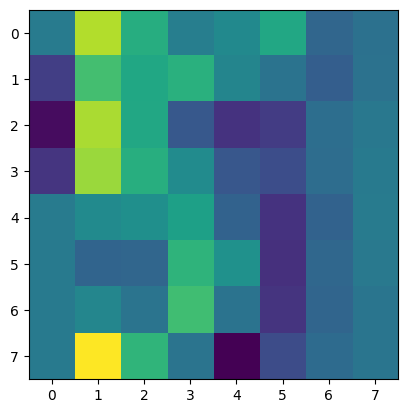

In [ ]:
# Your code here.
from scipy.stats import multivariate_normal
foo = multivariate_normal(gmm.means_[0], gmm.covariances_[0])
sample = foo.rvs()
plt.imshow(sample.reshape(8, 8))

## 3. Principal Component Analysis
In this set of exercises we will see how Principal Component Analysis (PCA) can be used to *simplify* the representation of input data in order to make visualize them or to make learning more stable. 

### Exercise 3.1: Fitting a Bayesian Generative Model

Fit a *Quadratic* generative model (e.g. `sklearn.discriminant_analysis.QuadraticDiscriminantAnalysis()`) to the Digits dataset. Observe *all* warnings that the model fitting procedure returns. How well does the trained model work?

**Note**: Since we are using a *supervised* model as a downstream task, you should *split* the dataset into training and test sets. 

In [ ]:
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis, LinearDiscriminantAnalysis

qdc = QuadraticDiscriminantAnalysis()
qdc.fit(Xs, ys)
(qdc.predict(Xs) == ys).mean()

C:\Users\leona\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\discriminant_analysis.py:935: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


0.9365609348914858

## Exercise 3.2: Removing "redundant" dimensions

Use *Principal Component Analysis (PCA)* to reduce the dimensionality of the digits dataset. You can use `sklearn.decomposition.PCA` for this. You should think carefully about how to choose the *number* of principal components to use. You should also think *very carefully* about which data is used to estimate the principal components. Use the transformed dataset to train and test a Bayes Quadratic classifier.

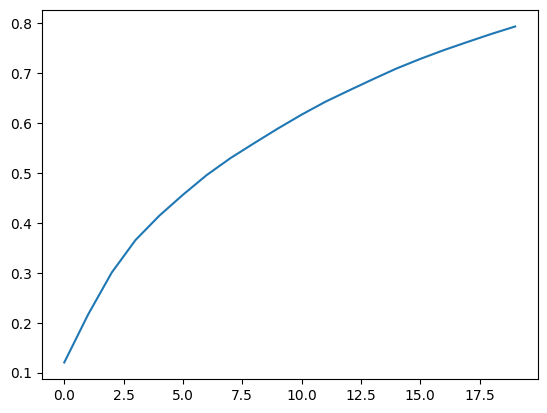

In [ ]:
from sklearn.decomposition import PCA

pca = PCA(n_components=20)
Xs_trans = pca.fit_transform(Xs)
Xs_trans.shape
plt.plot(np.cumsum(pca.explained_variance_ratio_))

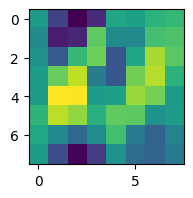

In [ ]:
qdc.fit(Xs_trans, ys)
(qdc.predict(Xs_trans) == ys).mean() ## good improvment 
plt.figure(figsize = (2, 3)); plt.imshow(pca.components_[0].reshape(8, 8))

### Exercise 3.3: PCA as a visualization tool

Transform the Digits dataset onto only *two* dimensions and visualize the dataset using a scatterplot. You can use `ys` to *color* the points in the scatterplot according to the true classes. Do the classes form natural clusters? Do some of them?

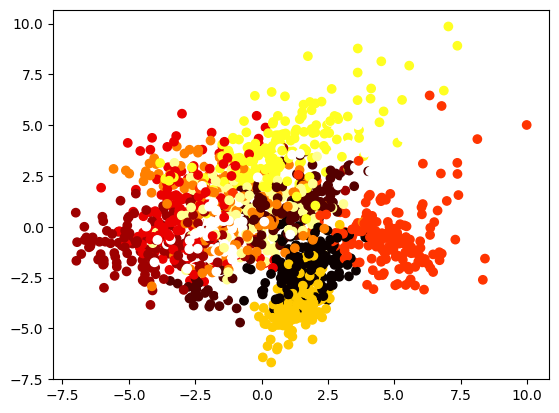

In [ ]:

plt.scatter(Xs_trans[:, 0], Xs_trans[:, 1], c = ys, cmap='hot')

### Exercise 3.4: TSNE for *better* visualization
PCA is severely limited by the fact that it finds a *linear* manifold of the original data. Use `sklearn.manifold.TSNE` instead to learn a 2-dimensional *nonlinear* manifold of digits. Repeat the visualization like before.